In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

import pydot


Using TensorFlow backend.


In [19]:
data_df = pd.read_parquet('../parquet/cropped/train_image_data_0.parquet', 'pyarrow')

In [2]:
IMG_SIZE = 64

In [3]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)


head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [4]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

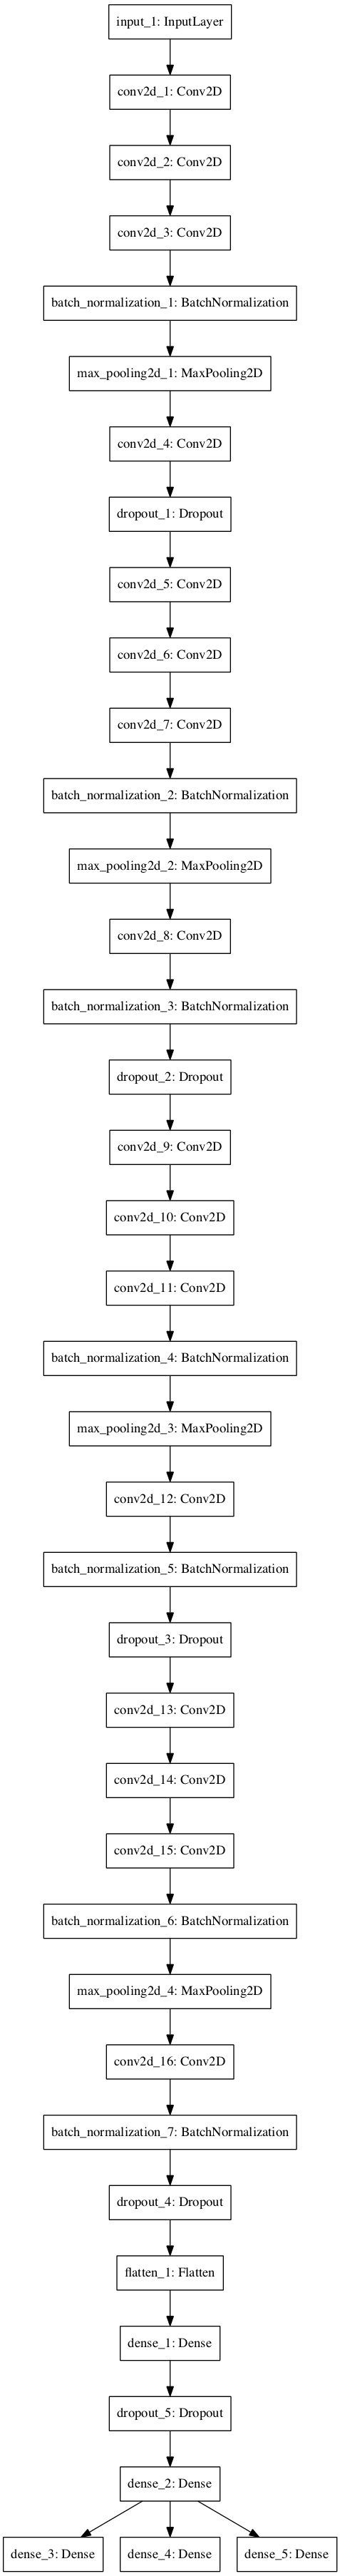

In [5]:
plot_model(model)

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [9]:
batch_size = 512
epochs = 36

In [10]:
class MultiOutputDataGenerator(ImageDataGenerator):
    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [11]:
HEIGHT = 137
WIDTH = 236